# Math 407 Final Project

Name: Yuyang Huang

ID: 1612042272

## Problem 1:
## Find a procedure for sampling uniformly on the surface of the sphere.

### Part (a): 
### Use computer to generate a thousand points that are random, independent, and uniform on the unit sphere, and print the resulting picture.

**Point Generating Process**:

>Point generating process reference from http://corysimon.github.io/articles/uniformdistn-on-sphere/

>Since we create a sphere with radius 1, so the sphere has a surface area 4π. We would like to let points uniformly distributed over the surface. 

>Therefore, the density function to have a point is 0.25π<sup>-1</sup>

>So we would like to use a parameterization in θ and ϕ to find the corresponding probability density function f(θ,ϕ) that maps to a uniform distribution on the sphere created

>> P{probability to have points}*dA=0.25π<sup>-1</sup>*dA=f(θ,ϕ)dθdϕ

>Since dA=sin⁡(ϕ)dϕdθ, we can get joint density:

>> f(θ,ϕ)=0.25π<sup>-1</sup>sin(ϕ)

>Inverse Transform Sampling is a way to sample a general probability distribution using a uniform random number. For this, we need the cumulative distribution function of ϕ:

>> F(ϕ)=∫<sub>0</sub><sup>ϕ</sup>f(ϕ̂ )dϕ̂ =12(1−cos(ϕ))

>Because F(ϕ) is a monotonically increasing function from [0,π]→[0,1], so it is a cumulative distribution function. 

>Thus, it has an inverse function F<sup>-1</sup>.

>> F<sup>-1</sup>(u)=arccos⁡(1−2u).

>Generate uniformly distributed random numbers on the sphere using code below, using C++


In [0]:
'''
#include<random>
#include<cmath>
#include<chrono>

int main(int argc, char *argv[]) {
	// Set up random number generators
	unsigned seed = std::chrono::system_clock::now().time_since_epoch().count();
	std::mt19937 generator (seed);
	std::uniform_real_distribution<double> uniform01(0.0, 1.0);

	// generate N random numbers
	int N = 1000;

	// the correct way
	FILE * correct;
	correct = fopen("correct.csv", "w");
	fprintf(correct, "Theta,Phi,x,y,z\n");
	for (int i = 0; i < N; i++) {
		double theta = 2 * M_PI * uniform01(generator);
		double phi = acos(1 - 2 * uniform01(generator));
		double x = sin(phi) * cos(theta);
		double y = sin(phi) * sin(theta);
		double z = cos(phi);
		fprintf(correct, "%f,%f,%f,%f,%f\n", theta, phi, x, y, z);
	}
	fclose(correct);
}
'''

We save out points to a  csv file

In [0]:
csv_path="/content/drive/My Drive/Course/Math 407/Part2/correct_yuyangh.csv"
num_points = 1000

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import csv
from mpl_toolkits.mplot3d import axes3d
from google.colab import drive
drive.mount('/content/drive')

In [0]:
def plot_sphere(xi, yi, zi): 
    '''
    plot those points using numpy library
    '''
    phi = np.linspace(0, np.pi, 20)
    theta = np.linspace(0, 2 * np.pi, 40)
    x = np.outer(np.sin(theta), np.cos(phi))
    y = np.outer(np.sin(theta), np.sin(phi))
    z = np.outer(np.cos(theta), np.ones_like(phi))
    
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d', 'aspect':'equal'})
    ax.plot_wireframe(x, y, z, color='k', rstride=1, cstride=1)
    ax.scatter(xi, yi, zi, s=90, c='blue', zorder=9)
    fig.set_figheight(10)
    fig.set_figwidth(10)

In [0]:
my_data = np.genfromtxt(csv_path, delimiter=',')
my_data = my_data[1:]
my_data.shape

(1000, 5)

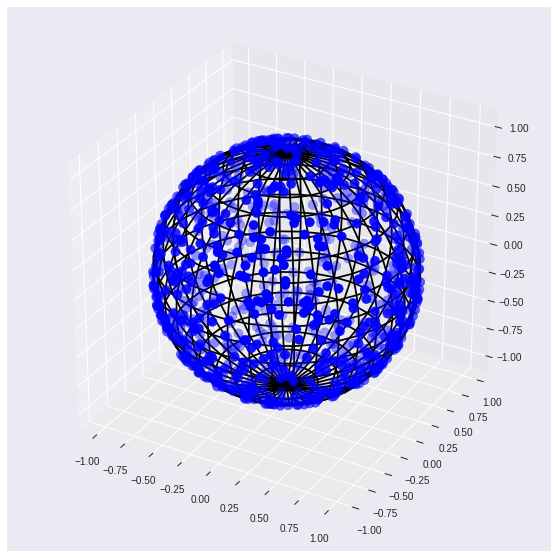

In [0]:
plot_sphere(my_data[:,2], my_data[:,3], my_data[:,4])


>

>

>


>

>

>

>


>

>

>

### Part (b):
### By putting sufficiently many independent uniform points on the surface of the Earth (not literally but using a computer model, of course), estimate the areas of Antarctica and Africa, compare your results with the actual values, and make a few comments (e.g. are the relative errors similar? would you expect them to be similar? if not, which one should be bigger? etc.)


Permitted by Debtanu Sen, I discussed with Yang Li, Vivian Zhu on libraries and plot functions in part b

In [0]:
!pip install -q fiona
!pip install -q geopandas
!pip install -q descartes
import fiona
import geopandas
import pandas as pd
import requests, zipfile, io
from shapely.ops import unary_union
from shapely.geometry import shape,mapping, Point, Polygon, MultiPolygon

In [0]:
def get_dataframe(name):
    file=geopandas.datasets.get_path('naturalearth_lowres')
    world = geopandas.read_file(file)
    world = world[world.continent == name]
    continents = world.dissolve(by='continent')
    return continents

In [0]:
def transform_xyz_to_long_lat(npoints, r, x, y, z): 
    '''
    converting carteisan coordiantes to longitude and latitude
    reference from https://gis.stackexchange.com/questions/120679
    '''
    longitude = np.zeros((npoints, ))
    latitude = np.multiply(np.arcsin(z / r), (180/np.pi))
    for i in range(longitude.shape[0]):
        if x[i] > 0:
            longitude[i] = np.multiply(np.arctan(y[i]/x[i]), (180/np.pi))
        elif y[i] > 0:
            longitude[i] = np.multiply(np.arctan(y[i]/x[i]), (180/np.pi)) + 180
        else:
            longitude[i] = np.multiply(np.arctan(y[i]/x[i]), (180/np.pi)) - 180
    return longitude, latitude
    

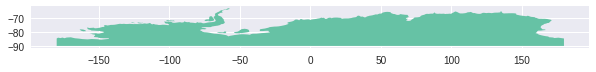

In [0]:
# get the data for Antarctica from the dataset
df_antarctica = get_dataframe('Antarctica')
df_antarctica.plot(cmap='Set2', figsize=(10, 10))

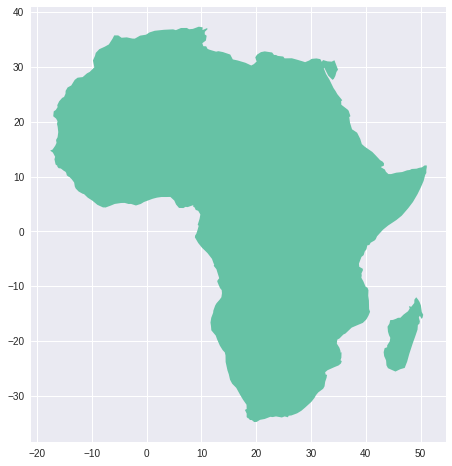

In [0]:
# get the data for Africa from the dataset
df_africa = get_dataframe('Africa')
df_africa.plot(cmap='Set2', figsize=(8,8))

In [0]:
longitude, latitude = transform_xyz_to_long_lat(1000, 1, my_data[:,2], my_data[:,3], my_data[:,4])

In [0]:
def generate_dataframe_points(longitude, latitude): 
    '''
    convert points in longitude, latitude to pandas.DataFrame object
    '''
    dataframe = pd.DataFrame({
        'Latitude': latitude,
        'Longitude': longitude
    })
    dataframe['geometry'] = list(zip(dataframe.Longitude, dataframe.Latitude))
    dataframe['geometry'] = dataframe['geometry'].apply(Point)
    points = geopandas.GeoDataFrame(dataframe, geometry='geometry')
    return points

In [0]:
points = generate_dataframe_points(longitude, latitude)

In [0]:
def count_points(name):
    '''
    check each points whether in boundary
    '''
    if name == 'Antarctica': 
        iswithin = points['geometry'].within(df_antarctica['geometry'].values[0])
        return np.count_nonzero(iswithin)
    elif name == 'Africa': 
        iswithin = points['geometry'].within(df_africa['geometry'].values[0])
        return np.count_nonzero(iswithin)

We get the real earth, Antarctica, and Africa area by searching on Google

The data's unit is in mi<sup>2<sup>

In [0]:
area_earth = 196.9 
area_antarctica = 5.045
area_africa = 11.73

In [0]:
cnt_antarctica = count_points('Antarctica')
approx_area_antarctica = cnt_antarctica / num_points * area_earth 
error_antarctica = (approx_area_antarctica - area_antarctica) / area_antarctica 
print ("Error for estimation of Antarctica is:", str(error_antarctica*100)+"%")

Error for estimation of Antarctica is: -10.233894945490588%


In [0]:
cnt_africa = count_points('Africa')
approx_area_africa = cnt_africa / num_points * area_earth
error_africa = (approx_area_africa - area_africa) / area_africa 
print ("Error for estimation of the area of Africa: ", str(error_africa*100)+"%")

Error for estimation of the area of Africa:  0.7161125319693062%


 **Conclusion**:

 > The estimation result's error is not similar.

 > > overestimate the area for Antarctica

 > > under estimate the area for Africa

 > I do not expect them to be similar because the Earth is not a perfect sphere.

 > Antarctica would be smaller because the Earth is more flat at the pole area.

 > There would have less area.







>

>

>

>


>

>

>

>

## Problem 2:
## Get a computer program for distinguishing a randomly generated sequence of zeroes and ones from a cooked-up one

We use existing library wald_wolfowitz

It checks a randomness hypothesis for a two-valued data sequence.

Reference from https://accendoreliability.com/the-wald-wolfowitz-run-test-for-two-small-samples/

To save computation time, some result is loaded from drive

**Hypothesis**

Null hypothesis:  h0: the sequence is not randomly generated. 

Alternative hypothesis: h1: the sequence is randomly generated. 

if p <0.05, we reject the null hypothesis


In [0]:
from skidmarks import wald_wolfowitz

In [0]:
def isRandom(example):
    r = wald_wolfowitz(example)
    return r['p']

In [0]:
def generate_ordered_binary(num):
    '''
    convert dec to binary
    append number < num into a string
    '''
    str=""
    for num in range(0,num+1):
      str+=(bin(num))[2:]
    return str

In [0]:
# generate numbers
def generate():
  for num in range(1,4):
    test_num=10**num
    test_number.append(test_num)
    all_runs.append(generate_ordered_binary(10**test_num))

In [0]:
all_runs=list()
test_number=list()

In [0]:
for num in [4,5,7,10,12,13,14,17]:
  test_number.append("2^"+str(num))
all_runs = [generate_ordered_binary(16),  
   open('/content/drive/My Drive/Course/Math 407/Part2/output_2^5.txt', 'r').read(), 
   open('/content/drive/My Drive/Course/Math 407/Part2/output_2^7.txt', 'r').read(), 
   open('/content/drive/My Drive/Course/Math 407/Part2/output_2^10.txt', 'r').read(), 
   open('/content/drive/My Drive/Course/Math 407/Part2/output_2^12.txt', 'r').read(),
   open('/content/drive/My Drive/Course/Math 407/Part2/output_2^13.txt', 'r').read(), 
   open('/content/drive/My Drive/Course/Math 407/Part2/output_2^14.txt', 'r').read(),
   open('/content/drive/My Drive/Course/Math 407/Part2/output_2^17.txt', 'r').read()]

In [0]:
all_p_values = [None]*len(all_runs)
all_is_random = [None]*len(all_runs)
for i in range(len(all_runs)):
    all_p_values[i] = isRandom(all_runs[i])
    all_is_random[i] = all_p_values[i] > 0.05

In [0]:
d = {'string': all_runs, 'p-value': all_p_values, 'is_random': all_is_random,'num_size':test_number}
df_random = pd.DataFrame(data=d)
df_random

,is_random,num_size,p-value,string
0,True,2^4,0.454813,0110111001011101111000100110101011110011011110...
1,True,2^5,0.534557,0110111001011101111000100110101011110011011110...
2,True,2^7,0.677137,0110111001011101111000100110101011110011011110...
3,True,2^10,0.859206,0110111001011101111000100110101011110011011110...
4,True,2^12,0.955852,0110111001011101111000100110101011110011011110...
5,True,2^13,0.984061,0110111001011101111000100110101011110011011110...
6,True,2^14,0.996670,0110111001011101111000100110101011110011011110...
7,True,2^17,1.000000,0110111001011101111000100110101011110011011110...


In [0]:
def is_prime(num):
    """Returns True if the number is prime
    else False."""
    if num == 0 or num == 1:
        return False
    for x in range(2, num):
        if num % x == 0:
            return False
    else:
        return True

In [0]:
def generate_prime(limit):
  result=list()
  for x in range(1,limit):
    for y in range(2,x//2):
      if x%y==0:
        break
      else:
        result.append(x)
  return result

In [0]:
def generate_binary_string(list):
    str=""
    for num in list:
      str+=(bin(num))[2:]
    return str

In [0]:
all_runs=list()
test_number=list()

In [0]:
for num in [3,4,5,6,7,8]:
  test_number.append("2^"+str(num))
all_runs=[open('/content/drive/My Drive/Course/Math 407/Part2/output_prime_2^3.txt', 'r').read(),
    open('/content/drive/My Drive/Course/Math 407/Part2/output_prime_2^4.txt', 'r').read(),
    open('/content/drive/My Drive/Course/Math 407/Part2/output_prime_2^5.txt', 'r').read(),
    open('/content/drive/My Drive/Course/Math 407/Part2/output_prime_2^6.txt', 'r').read() , 
    open('/content/drive/My Drive/Course/Math 407/Part2/output_prime_2^7.txt', 'r').read(), 
    open('/content/drive/My Drive/Course/Math 407/Part2/output_prime_2^8.txt', 'r').read()]

In [0]:
all_p_values = [None]*len(all_runs)
all_is_random = [None]*len(all_runs)
for i in range(len(all_runs)):
    all_p_values[i] = isRandom(all_runs[i])
    all_is_random[i] = all_p_values[i] > 0.05

In [0]:
d = {'string': all_runs, 'p-value': all_p_values, 'is_random': all_is_random,'num_size':test_number}
df_random = pd.DataFrame(data=d)
df_random

,is_random,num_size,p-value,string
0,True,2^3,0.661974,011011101111
1,True,2^4,0.825477,01101110111110111101
2,True,2^5,0.407941,011011101111101111011000110011101111110111111
3,True,2^6,0.813018,0110111011111011110110001100111011111101111111...
4,True,2^7,0.221877,0110111011111011110110001100111011111101111111...
5,True,2^8,0.082379,0110111011111011110110001100111011111101111111...


After 2^8, checking prime is pretty slow for Python.

**Conclusion**:

 > The sequence consisting of the concatenation of all numbers in binary form is random under 2^17
 
 > The sequence consisting of the concatenation of all prime numbers in binary form is random under 2^8

 > With increasing p value, I speculate with increasing value, the concatenation of all numbers will still be random

 > But the prime number concatenation has decreasing p value. So it might be random after certain number